# Idea
1. Get a bunch of album covers sorted by genre
2. Extract key colors from each album cover
3. Divide the HSUV (similar to HSV) color wheel into 12 slices, one for each note
4. Classify each color by the region it fits into
5. For each genre, find the most popular color for each slice. For example, find "rock red", "EDM green" etc.

![HSL color wheel](https://codropspz-tympanus.netdna-ssl.com/codrops/wp-content/uploads/2015/01/hsl-color-wheel.png)

### Problem Statement
Goal: Create 16 colorschemes, each consisting of 12 colors. Each colorscheme should be representative of one genre of music. The colors in each scheme should be capable of representing the 12 notes of the chromatic scale with details such as intervals represented well. Each color can vary in hue and saturation, but lightness is already used for loudness.

## Colorthief
This python package picks the most integral colors in an image. This makes sense for our problem, as most album covers are art with a limited palette of colors, and even photographs have a limited palette of representative colors. Choosing just a few colors per image simplifies our task greatly.

In [5]:
!pip install colorthief

## HSUV Colorscheme
The RGB colorscheme is not perceptually uniform. Basically, a 1" change on the color wheel looks like a different amount of change depending on where it is placed. RGB can be separated into Hue, Saturation, and Value components to better suit our task, but this is also not perceptually uniform. HSUV was created based on human experiments, and fixes this problem. It exists as an easy-to-use python package to convert from RGB.

In [11]:
!pip install hsluv

In [3]:
%matplotlib inline

In [6]:
import json
from pathlib import Path
from glob import glob
from colorthief import ColorThief
from PIL import Image
import IPython.display as ipd
import numpy as np
import random
import pandas as pd
from tqdm.auto import tqdm
from color_utils import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

In [ ]:
imgs = glob("covers/**/*.png")
imgs.extend(glob("covers/**/*.jpg"))

In [ ]:
len(imgs)

## Utilities

In [7]:
def rgb2hex(rgb):
    return '#%02x%02x%02x' % rgb

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    try:
        return tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))
    except:
        print(value, lv)
        return (0, 0, 0)

In [8]:
def showpalette(p):
    for c in p:
        ipd.display(Image.new('RGB', (512, 40), c))

In [9]:
def get_seg(hex_color):
    """ Divides HSL color wheel into 12 segments and returns segment of given hex color
    """
    h, s, l = rgb_to_hsluv(hex_to_rgb(hex_color))
    seg = round(h / (360 / 12))
    return seg

In [10]:
rgb_borders = [hsluv_to_hex((30*i, 50, 50)) for i in range(12)]

NameError: name 'hsluv_to_hex' is not defined

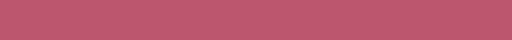

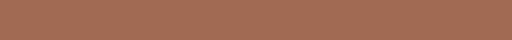

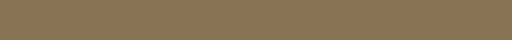

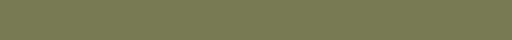

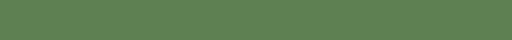

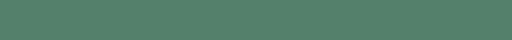

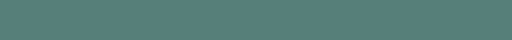

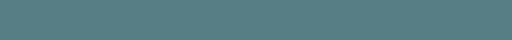

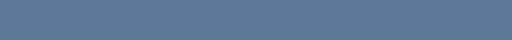

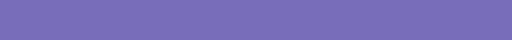

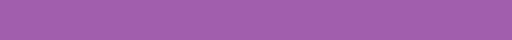

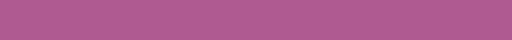

In [989]:
showpalette(rgb_borders)

In [1]:
rgbs2 = [rgb2hex(tuple(int(x) for x in hsl_to_rgb((1/12)*i, -0.5, 100))) for i in range(12)]

NameError: name 'rgb2hex' is not defined

## RGB Equidistant Colors

In [2]:
showpalette(rgbs2)

NameError: name 'showpalette' is not defined

In [956]:
rgb_to_hsl(129, 128, 128)

(0.0, -0.00392156862745098, 128.5)

## Test

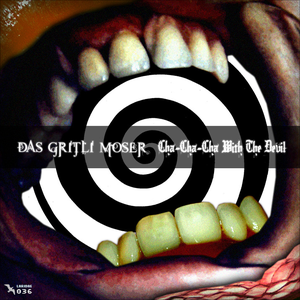

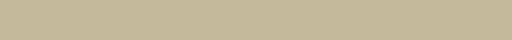

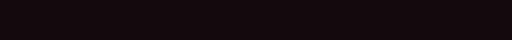

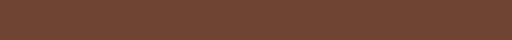

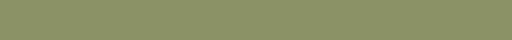

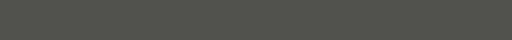

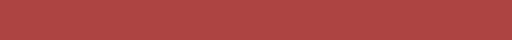

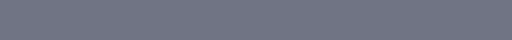

[2, 12, 1, 3, 3, 0, 9]

In [990]:
f = random.choice(imgs)
ct = ColorThief(f)

p = ct.get_palette(color_count=8, quality=10)
p = [rgb2hex(x) for x in p]

ipd.display(ipd.Image(f))
showpalette(p)
[get_seg(x) for x in p]

In [991]:
def pie_swatch(p, title=""):
    fig = plt.figure()
    patches, texts = plt.pie([1]*len(p), colors=p, shadow=False, startangle=180)
    plt.legend(patches, p, loc='best')
    plt.tight_layout()
    plt.axis('equal')
    plt.title(title)
    plt.show()
    return fig

## Create Color Dictionary

In [992]:
with open("../genre_to_top.json") as f:
    genre_to_top = json.load(f)

In [993]:
color_dict = {}
for img in tqdm(imgs):
    try:
        ct = ColorThief(img)
        prgb = ct.get_palette(color_count=8, quality=10)
        p = [rgb2hex(x) for x in prgb]
        genre = genre_to_top[img.split('/')[1]]

        #ipd.display(ipd.Image(img))
        #showpalette(p)

        for c in p:
            try:
                seg = get_seg(c)
                if seg is None:
                    continue
            except:
                continue

            if genre not in color_dict.keys():
                color_dict[genre] = {}

            if seg not in color_dict[genre]:
                color_dict[genre][seg] = {}

            if c not in color_dict[genre][seg]:
                color_dict[genre][seg][c] = 0

            color_dict[genre][seg][c] += 1
    except Exception as E:
        print(E)

cannot identify image file 'covers/Blues/America.png'



In [995]:
def get_rand_pal(genre):
    return [random.choice(list(color_dict[genre][seg].keys())) for seg in range(12) if seg in color_dict[genre].keys()]

In [996]:
import operator
def get_mode_pal(genre):
    """ Creates a palette from the most common colors in each segment
    """
    return [max(color_dict[genre][seg].items(), key=operator.itemgetter(1))[0] for seg in range(12) if seg in color_dict[genre].keys()]

In [997]:
def mean_color(cdict):
    rgbs = [hex_to_rgb(x) for x in cdict.keys()]
    weights = list(cdict.values())
    rs, gs, bs = zip(*rgbs)
    mr, mg, mb = [int(round(np.average(x, weights=weights, axis=0))) for x in [rs, gs, bs]]
    mc = rgb_to_hsl(mr, mg, mb)
    mc = (mc[0], mc[1], 0.5)
    mc = hsl_to_rgb(*mc)
    mc = tuple(int(round(x*256)) for x in mc)
    return rgb2hex(mc)

In [998]:
def get_mean_pal(genre):
    return [mean_color(color_dict[genre][seg]) for seg in range(12) if seg in color_dict[genre].keys()]

## Clustering

In [999]:
from sklearn.cluster import KMeans

In [1000]:
from hsluv import *

In [1001]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [1045]:
def get_cluster_palette(genre):
    g_weights = [list(color_dict[genre][x].values()) for x in color_dict[genre].keys()]
    g_weights = flatten(g_weights)
    g_weights = [pow(x, 2) for x in g_weights]
    g_colors = [list(color_dict[genre][x].keys()) for x in color_dict[genre].keys()]
    g_colors = flatten(g_colors)
    g_colors = np.array([hex_to_hsluv(x) for x in g_colors])
    kms = KMeans(n_clusters=12).fit(g_colors, sample_weight=g_weights)
    centers = kms.cluster_centers_
    centers = centers[centers[:,0].argsort()]
    # boost saturation for LEDs
    #centers[:,1] = np.minimum(centers[:,1]+40, 100)
    centers[:,1] = 100
    #centers[:,2] = 70
    center_colors = [hsluv_to_hex(tuple(centers[i,:])) for i in range(12)]
    return center_colors

In [1046]:
!mkdir palettes

mkdir: cannot create directory ‘palettes’: File exists


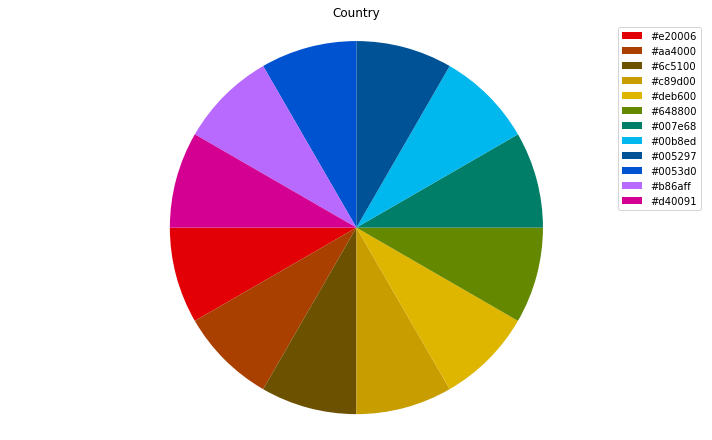

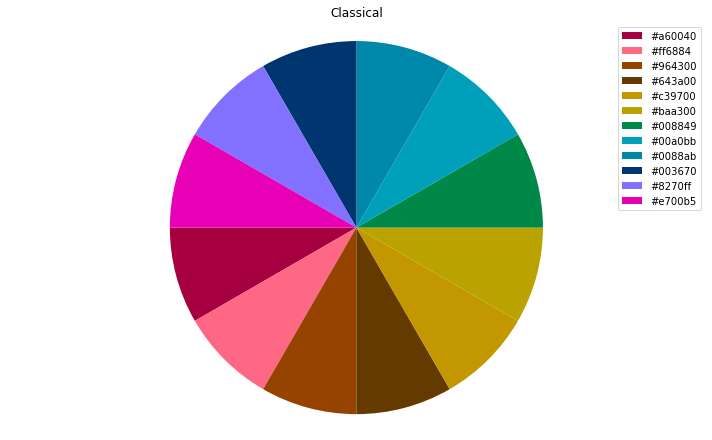

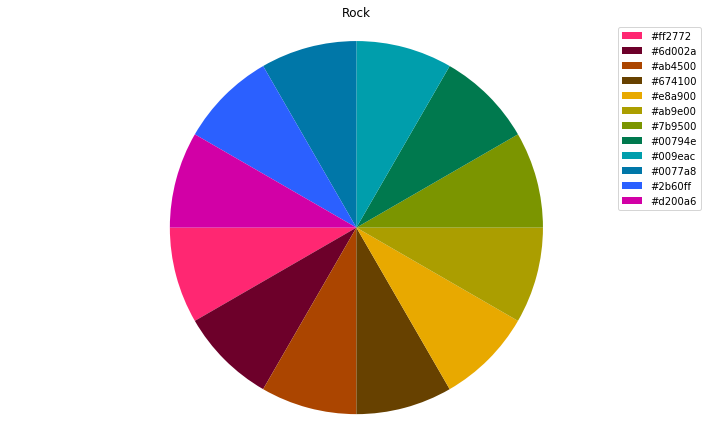

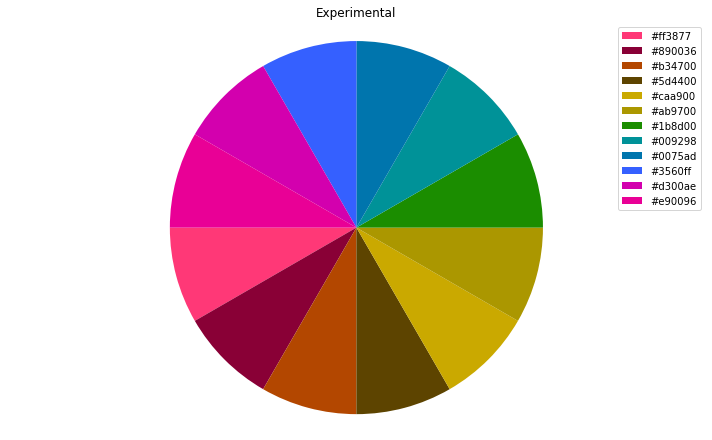

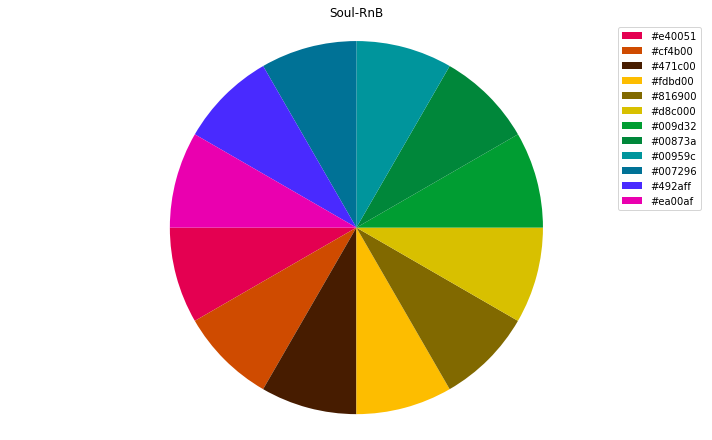

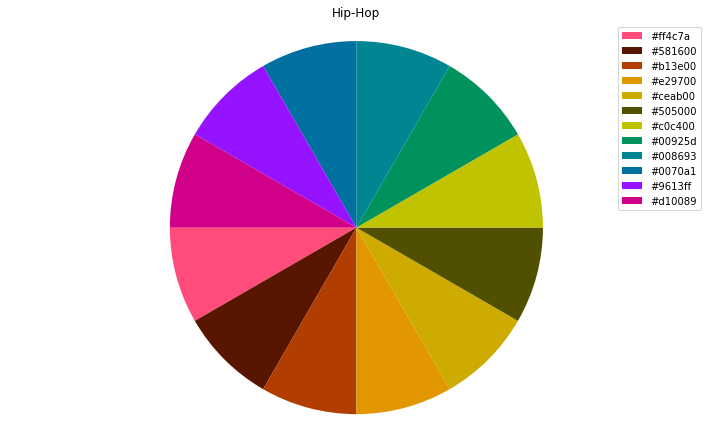

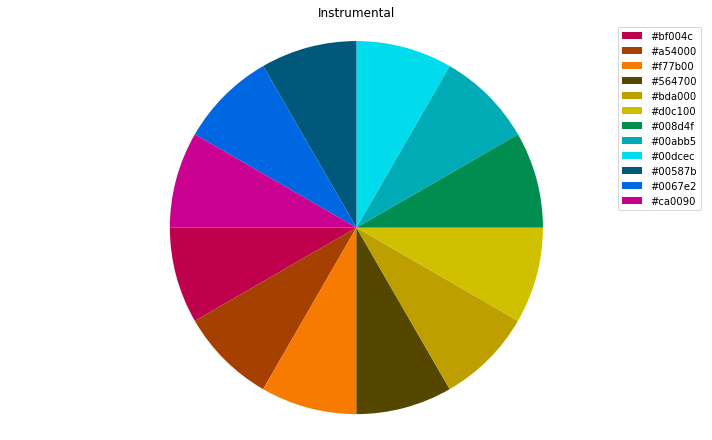

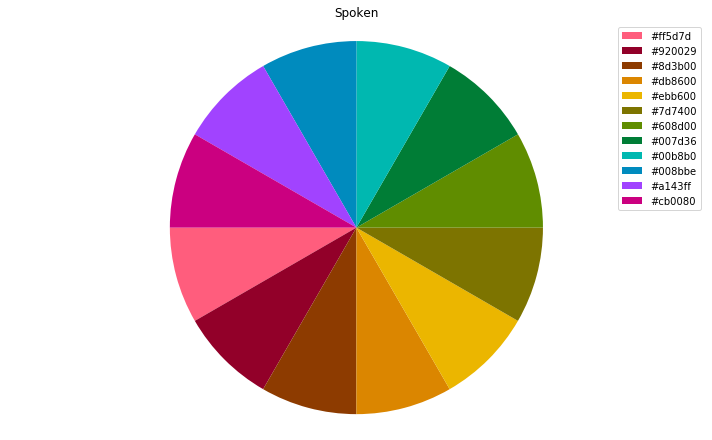

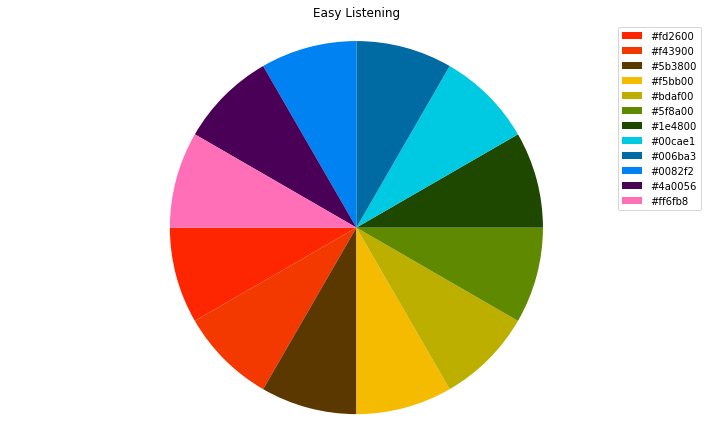

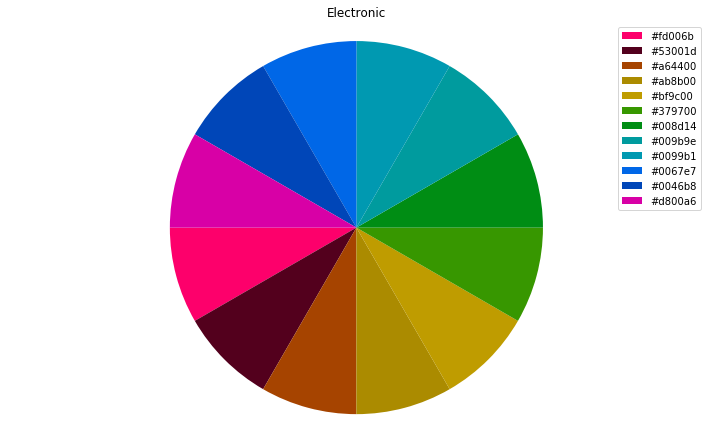

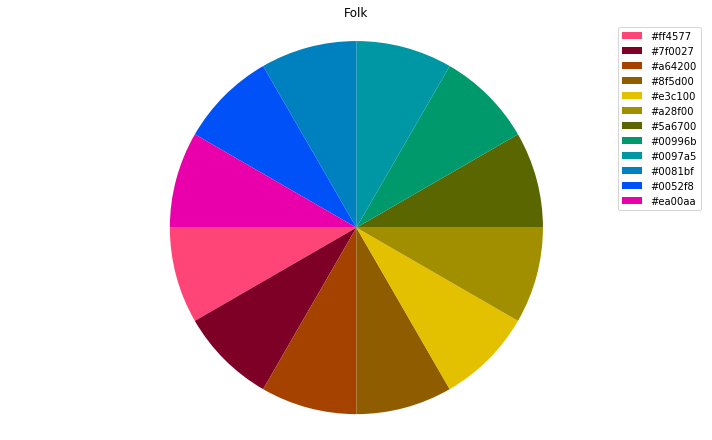

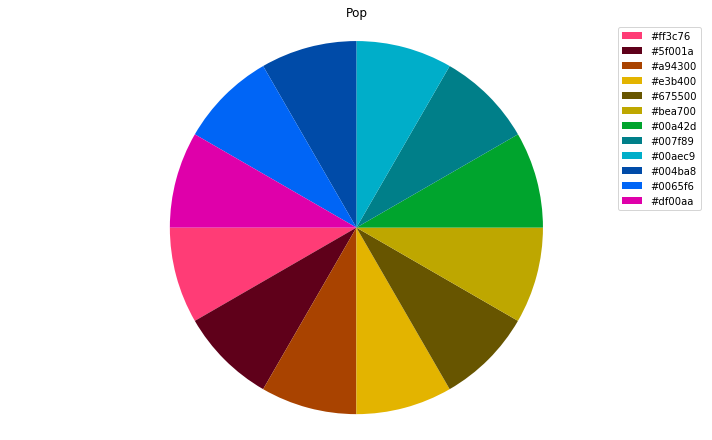

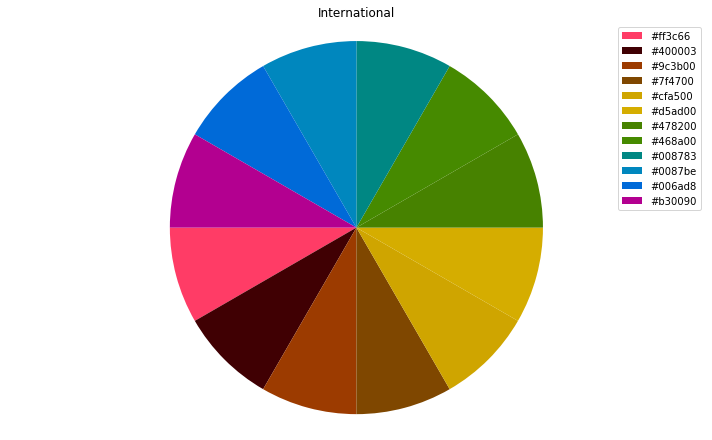

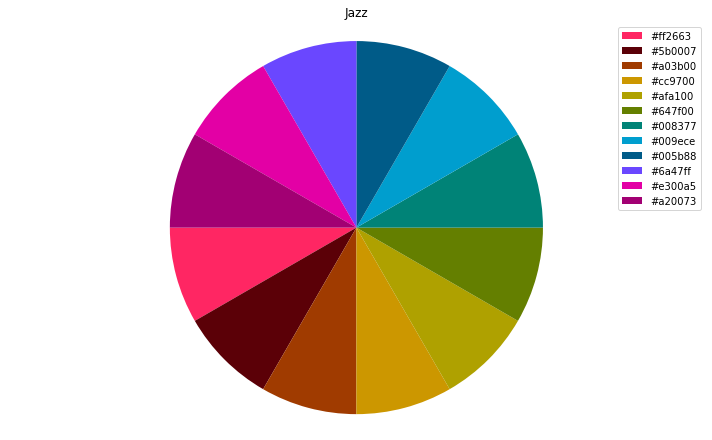

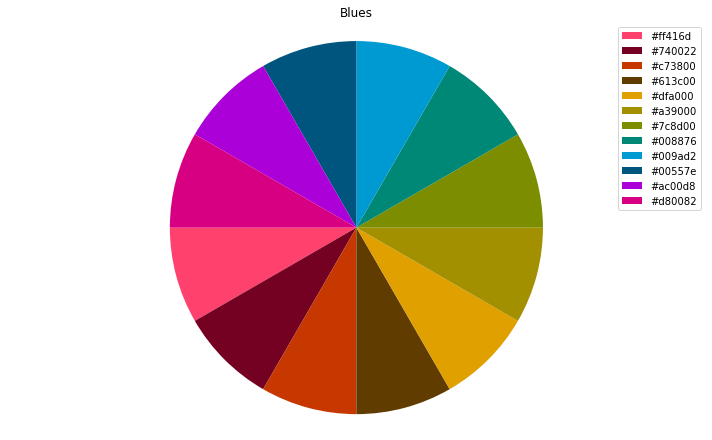

In [1047]:
for i,genre in enumerate(color_dict.keys()):
    fig = pie_swatch(get_cluster_palette(genre), title=genre)
    fig.subplots_adjust(top=0.88)
    fig.savefig("palettes/"+genre+"_cluster"+".png")

In [1048]:
!cd palettes && rm montage.png && montage *.png -mode Concatenate -tile 4x4 montage.png

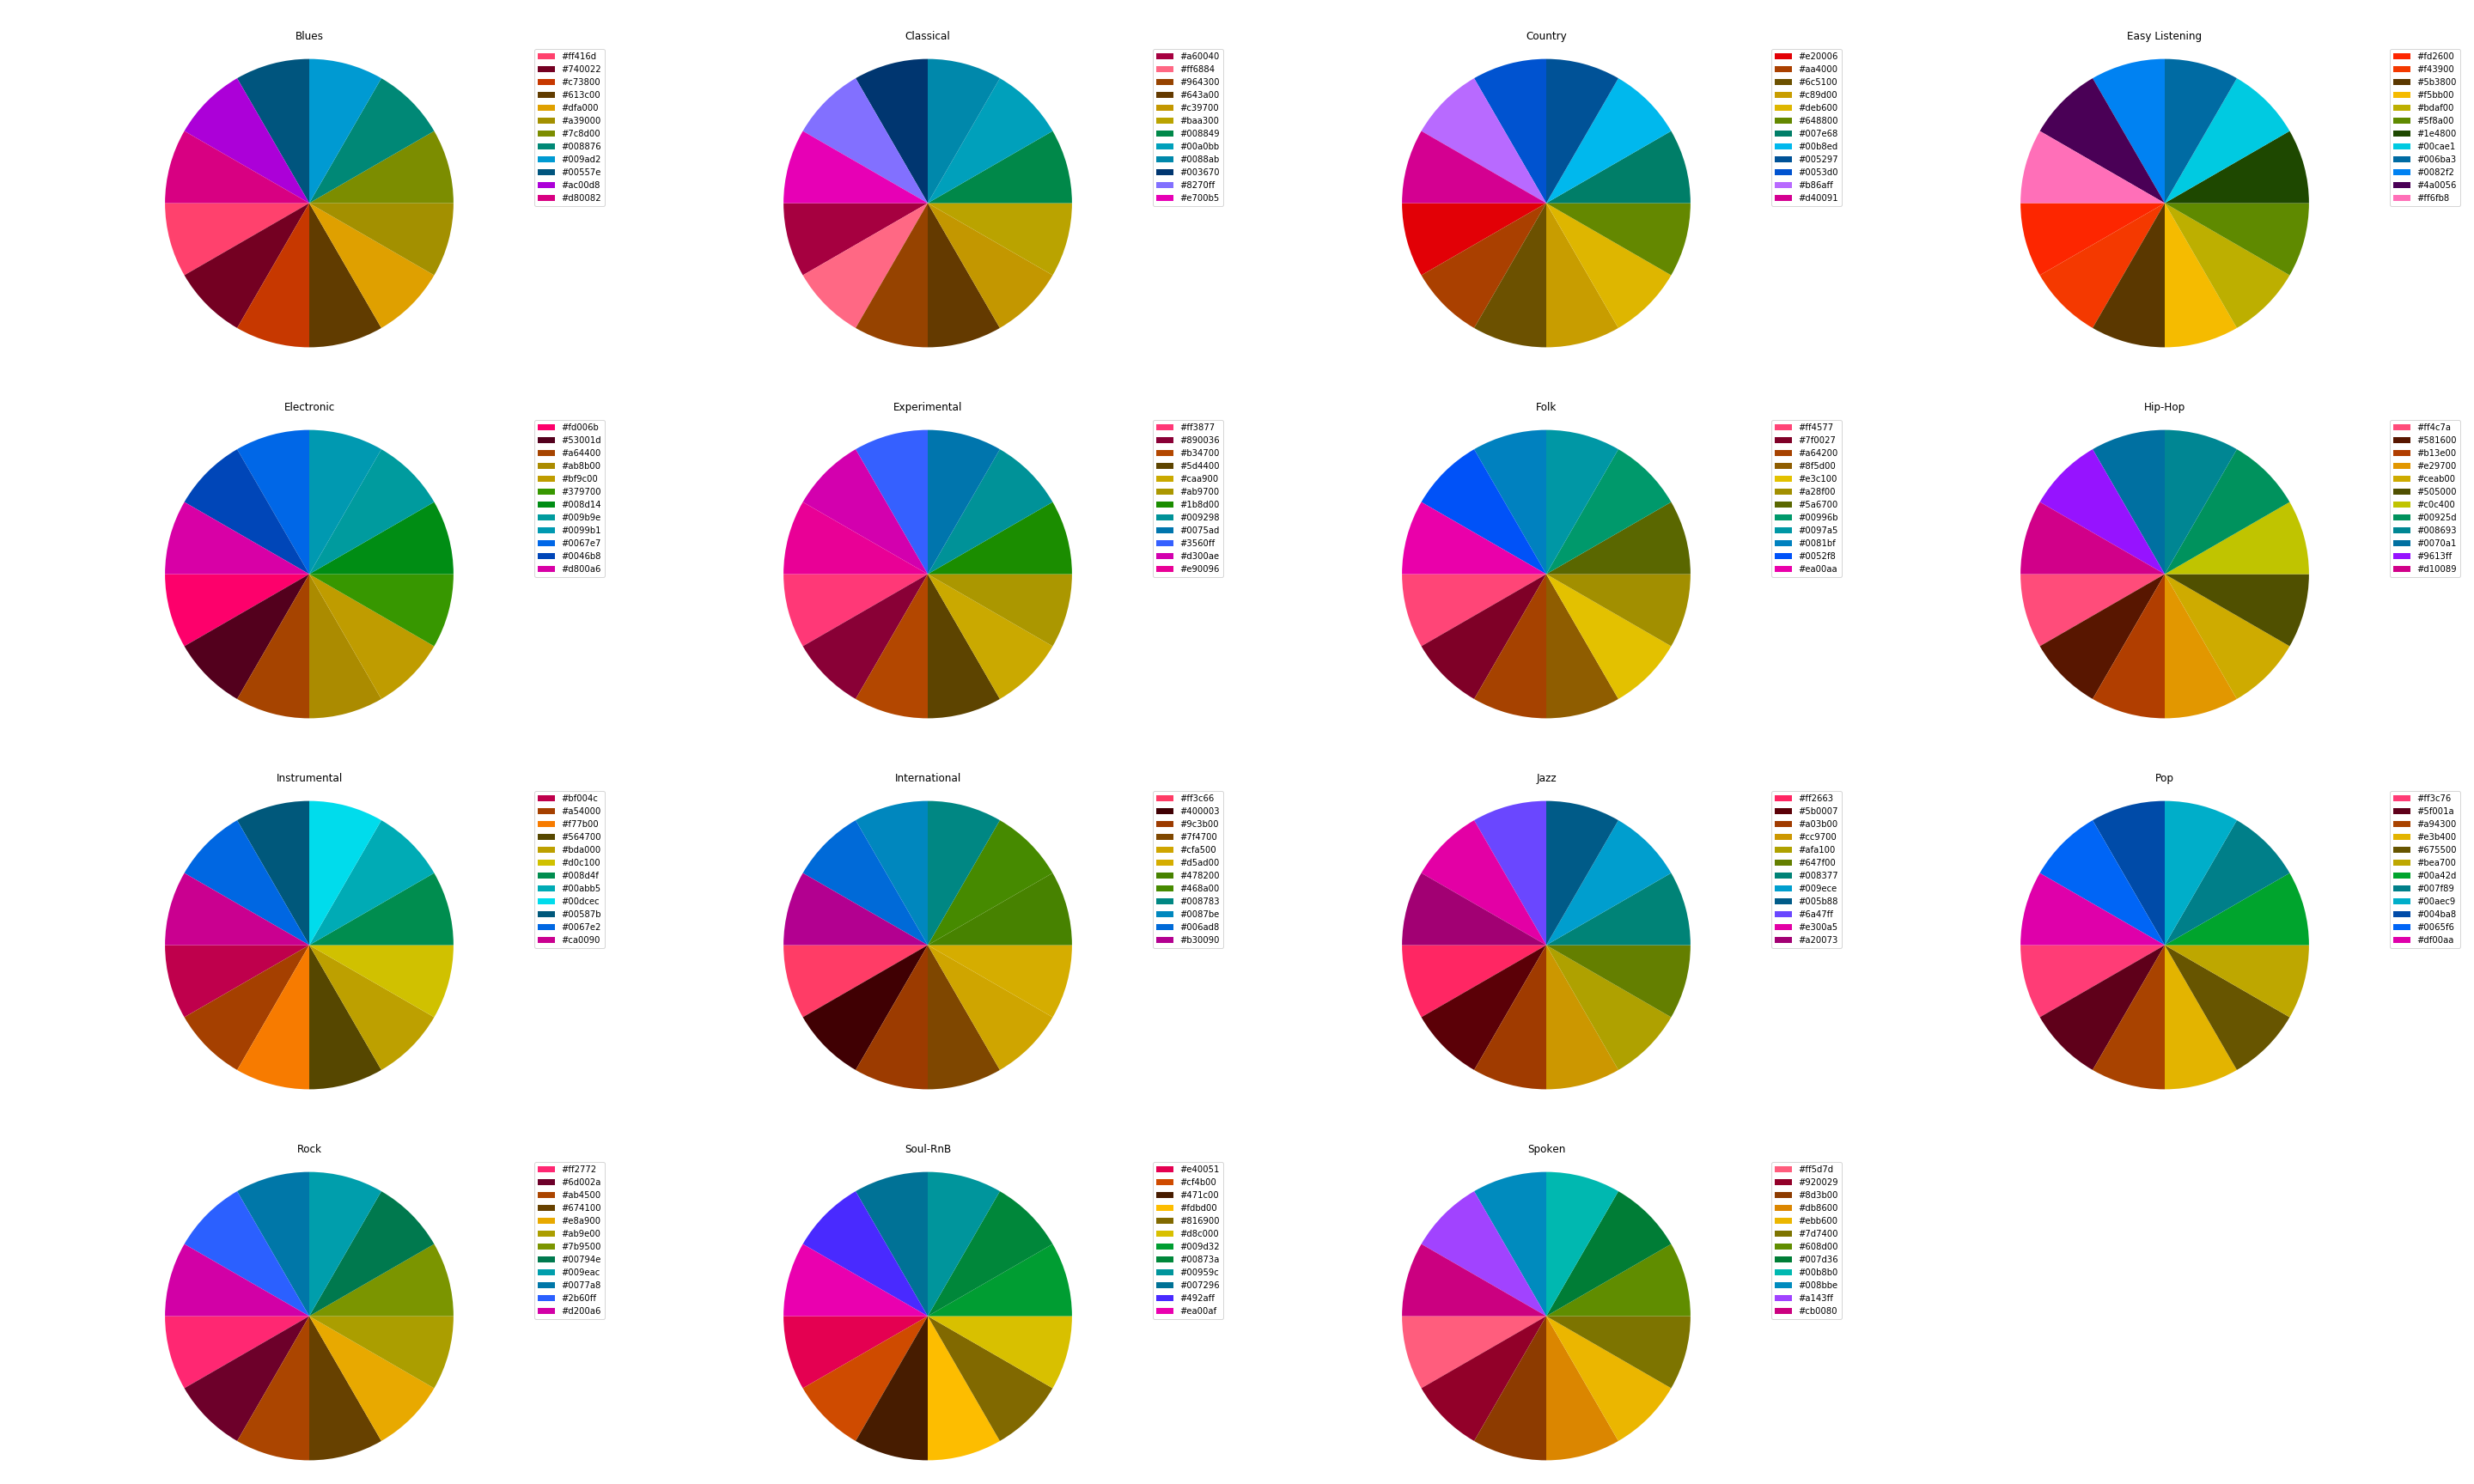

In [1049]:
ipd.Image("palettes/montage.png")

## Genre combination ideas:
+ Jazz /Blues
+ Country/Folk
+ Remove easy listening?


## Save colors to JSON

In [829]:
colors_tosave = {}
for g in color_dict.keys():
    colors_tosave[g] = get_cluster_palette(g)

In [835]:
with open("colors.json", 'w+') as f:
    json.dump(colors_tosave, f)

In [ ]:
with open("../genre_to_top.json") as f:
    top_gs =